# PBI KALBE
## Machine Learning Challenge

In [1]:
# IMPORT LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
import pmdarima as pm
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00


In [2]:
# LOAD DATA
df_customer = pd.read_csv('Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv('Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv('Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

In [3]:
# EDA
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [4]:
df_customer.dtypes

CustomerID         int64
Age                int64
Gender             int64
Marital Status    object
Income            object
dtype: object

In [5]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [6]:
# FILL MISSING VALUES
df_customer.fillna(method='ffill', inplace=True)

# CONVERT CATEGORICAL TO NUMERICAL
df_customer['Marital Status'] = df_customer['Marital Status'].apply(lambda x: 1 if x == 'Married' else 0)

# CONVERT INCOME INTO FLOAT DATA TYPE
df_customer['Income'] = df_customer['Income'].apply(lambda x: x.replace(',', '.')).astype(float)

In [7]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,1,5.12
1,2,60,1,1,6.23
2,3,32,1,1,9.17
3,4,31,1,1,4.87
4,5,58,1,1,3.57


In [9]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [10]:
df_transaction.dtypes

TransactionID    object
CustomerID        int64
Date             object
ProductID        object
Price             int64
Qty               int64
TotalAmount       int64
StoreID           int64
dtype: object

In [11]:
# CONVERT DATE DATA TYPE TO datetime
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')

In [12]:
# MERGE df_transaction AND df_customer
merged_df = pd.merge(df_transaction, df_customer, on='CustomerID', how='left')
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,1,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44,1,1,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27,1,0,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,1,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33,0,1,6.95


In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   int64         
 11  Income          5020 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 509.8+ KB


In [14]:
# AGGREGATE DATA
agg = {
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}
cluster_df = merged_df.groupby('CustomerID').aggregate(agg).reset_index()
cluster_df.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [15]:
# SCALE INTO SIMILAR RANGE
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cluster_df[['TransactionID', 'Qty', 'TotalAmount']])
scaled_df = pd.DataFrame(scaled_df, columns=['TransactionID', 'Qty', 'TotalAmount'])
scaled_df.head()

,TransactionID,Qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347


### CLUSTERING

In [16]:
# FINDING OPTIMAL NUMBER
inertia = []
max_clusters = 11
for n_cluster in range(1, max_clusters):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
    kmeans.fit(cluster_df.drop('CustomerID', axis=1))
    inertia.append(kmeans.inertia_)

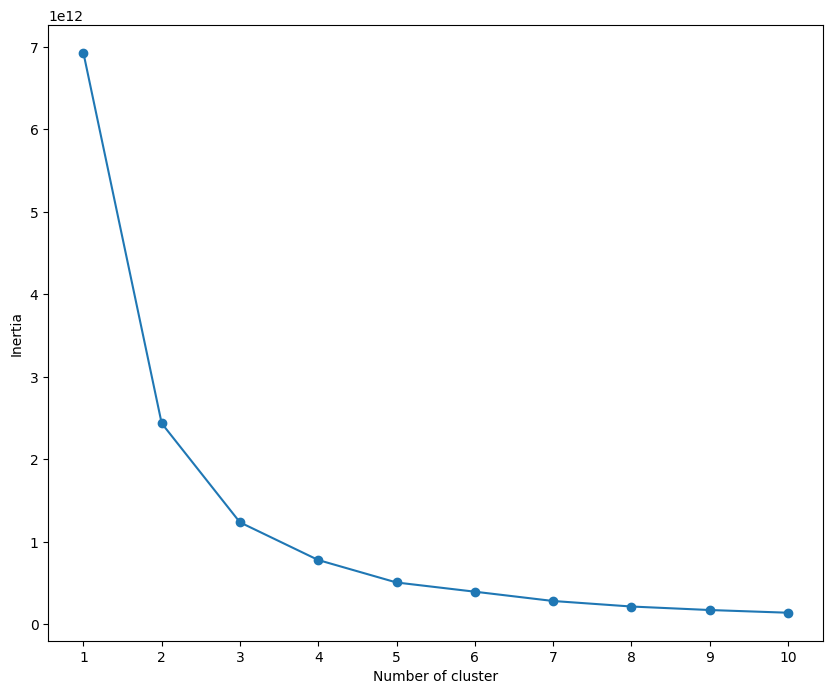

In [17]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, max_clusters), inertia, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.xticks(np.arange(1, max_clusters))
plt.show()

From the graph above we can decide that the number of cluster that doesn't signifcant is 3

In [18]:
# CREATE THE CLUSTER
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
kmeans.fit(cluster_df.drop('CustomerID', axis=1))
cluster_df['Cluster'] = kmeans.labels_

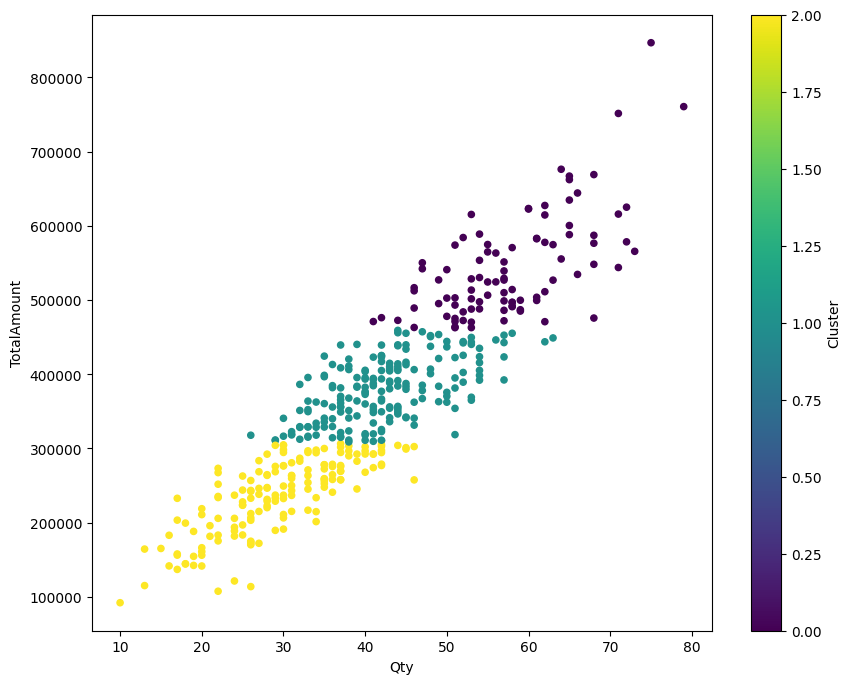

In [19]:
# PLOT THE CLUSTER
cluster_df.plot(kind='scatter', x='Qty', y='TotalAmount', c='Cluster', cmap='viridis', figsize=(10,8), legend=True)
plt.show()

In [30]:
#--
# MERGE DATA
merged_df = pd.merge(df_transaction, df_product, on='ProductID', how='left')
merged_df = pd.merge(merged_df, df_store, on='StoreID', how='left')
merged_df = pd.merge(merged_df, df_customer, on='CustomerID', how='left')
merged_df

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",36,0,1,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,10000,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",44,1,1,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",27,1,0,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",48,1,1,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,10000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",33,0,1,6.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR54423,243,2022-12-31,P10,15000,5,75000,3,Cheese Stick,15000,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529",38,0,1,3.34
5016,TR5604,271,2022-12-31,P2,3200,4,12800,9,Ginger Candy,3200,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",29,0,1,4.74
5017,TR81224,52,2022-12-31,P7,9400,6,56400,9,Coffee Candy,9400,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",37,0,1,3.73
5018,TR85016,18,2022-12-31,P8,16000,3,48000,13,Oat,16000,Buana,Buana,General Trade,"-1,26916","116,825264",47,0,1,13.60


In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   Price_y         5020 non-null   int64         
 10  StoreName       5020 non-null   object        
 11  GroupStore      5020 non-null   object        
 12  Type            5020 non-null   object        
 13  Latitude        5020 non-null   object        
 14  Longitude       5020 non-null   object        
 15  Age 

REGRESSION

In [24]:
# DF FOR REGRESSION
reg_df = df_transaction.groupby('Date')['Qty'].sum().reset_index()
reg_df['Date'] = pd.to_datetime(reg_df['Date'], format='%d/%m/%Y')
reg_df.sort_values(by='Date', inplace=True)
reg_df.set_index('Date', inplace=True)

<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Qty'>

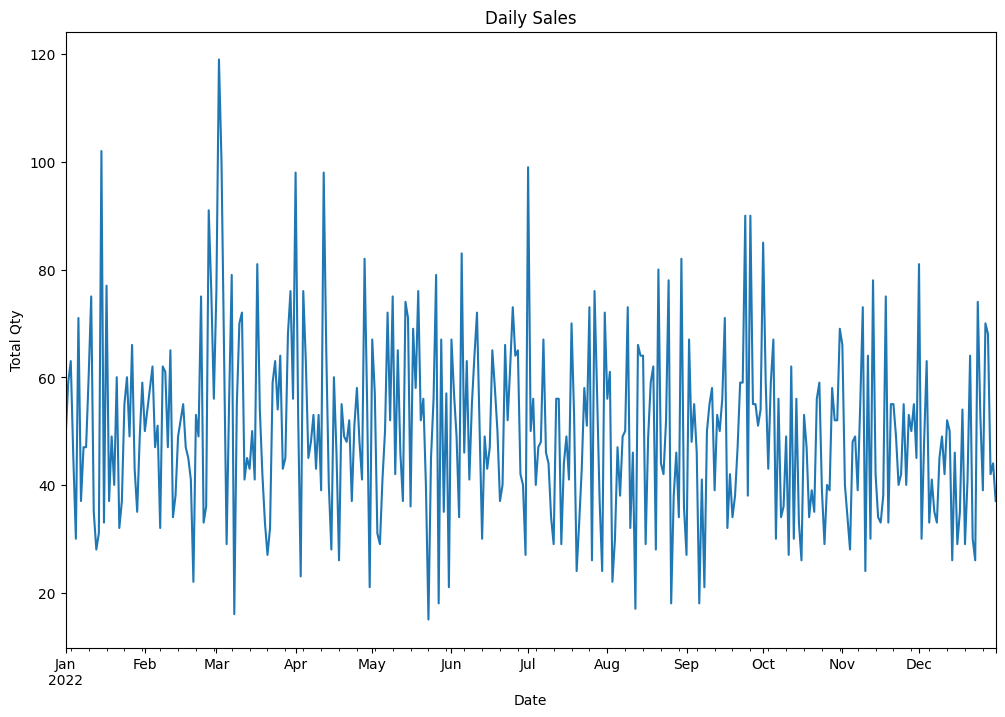

In [25]:
# qty SALES IN A YEAR
reg_df.plot(figsize=(12,8), title='Daily Sales', xlabel='Date', ylabel='Total Qty', legend=False)

In [26]:
# SPLIT DATA FOR TRAINING AND TESTING
train = reg_df[:int(0.8*(len(reg_df)))]
test = reg_df[int(0.8*(len(reg_df))):]

In [27]:
# GRID SEARCH (p, d, and q)
auto_arima_model = pm.auto_arima(
    train['Qty'],
    seasonal=False,
    stepwise=False,
    suppress_warnings=True,
    trace = True
)
auto_arima_model.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.45 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.46 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2758.656, Time=0.65 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2742.865, Time=0.86 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.67 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.43 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2510.161, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.29 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1249.469
Date:                Fri, 27 Oct 2023   AIC                           2504.937
Time:                        14:12:44   BIC                           2515.968
Sample:                    01-01-2022   HQIC                          2509.356
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.08e-05   3.25e+04      0.000       1.000       1.000
ma.L1         -0.9898      0.015    -66.556      0.000      -1.019      -0.961
sigma2       298.6887     22.254     13.422      0.000     255.072     342.306
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                18.30
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# IMPORT SARIMAX
p, d, q = auto_arima_model.order
model = SARIMAX(train['Qty'].values, order=(p,d,q))
model_fit = model.fit(disp=False)

In [29]:
# RMSE
from sklearn.metrics import mean_squared_error
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
rmse = mean_squared_error(test, predictions, squared=False)
rmse

14.153760587024204

In [42]:
# FORECASTING
period = 90
forecast = model_fit.forecast(steps=period)
index = pd.date_range(start='01-01-2023', periods=period)
df_forecast = pd.DataFrame(forecast, index=index, columns=['Qty'])

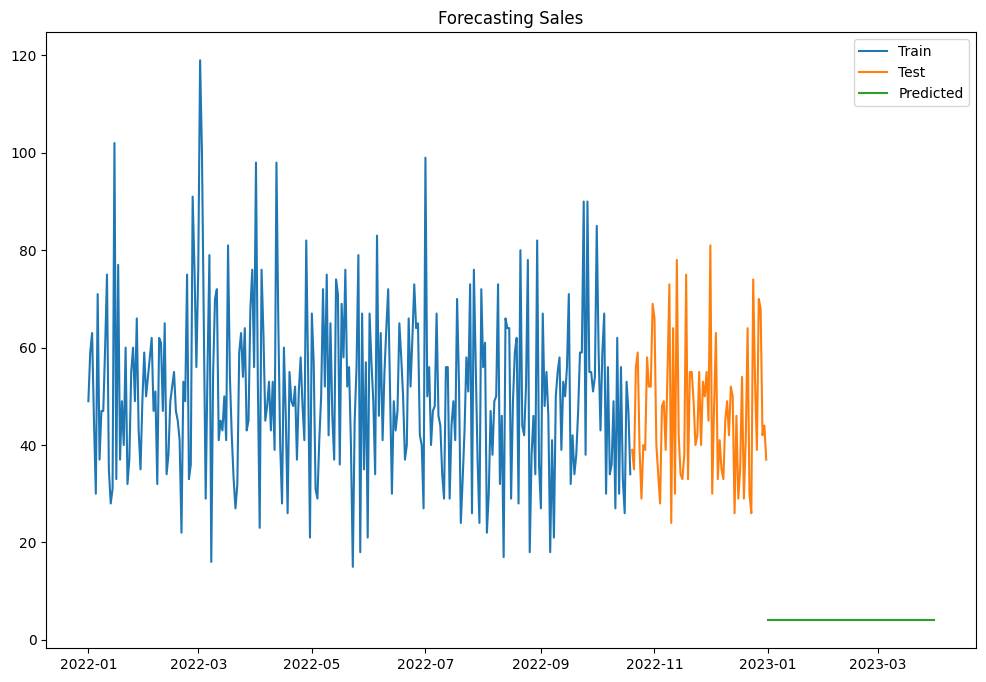

In [43]:
plt.figure(figsize=(12,8))
plt.title('Forecasting Sales')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(df_forecast, label='Predicted')
plt.legend(loc='best')
plt.show()

<Axes: title={'center': 'Forecasting Sales'}, xlabel='Date', ylabel='Total Qty'>

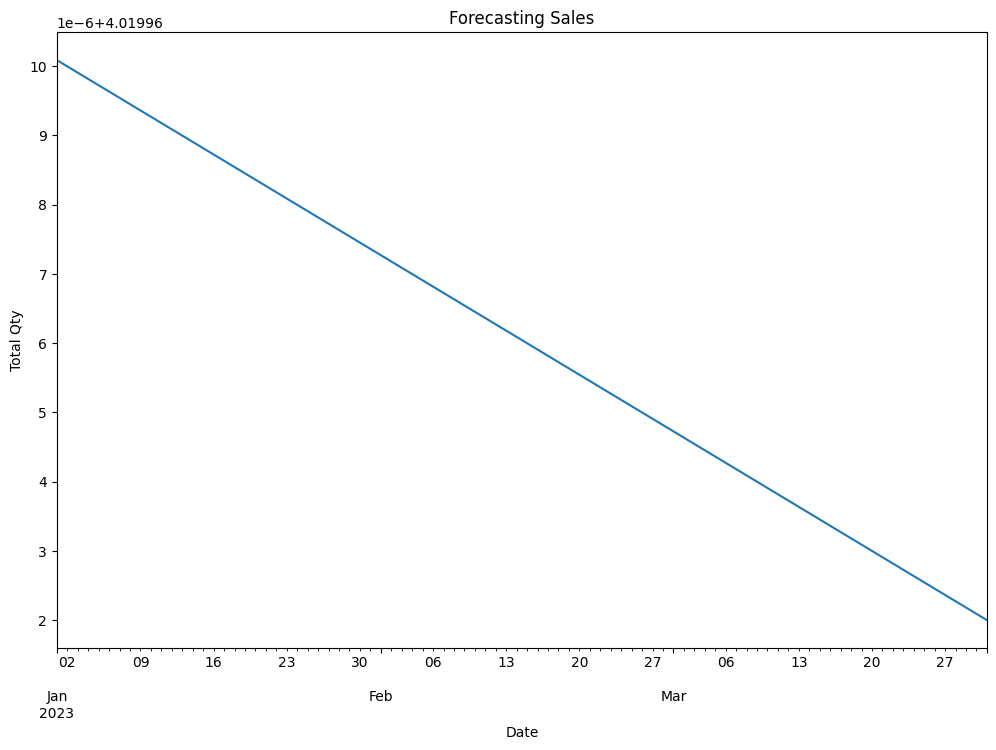

In [44]:
df_forecast.plot(figsize=(12,8), title='Forecasting Sales', xlabel='Date', ylabel='Total Qty', legend=False)

In [45]:
# FORECAST
warnings.filterwarnings('ignore')

product_reg_df = merged_df[['Qty', 'Date', 'Product Name']]
new = product_reg_df.groupby("Product Name")

forecast_product_df = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=90)})

for product_name, group_data in new:
    target_var = group_data['Qty']
    model = SARIMAX(target_var.values, order=(p,d,q))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(90)
    forecast_product_df[product_name] = forecast

forecast_product_df.set_index('Date', inplace=True)
forecast_product_df.head()

,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
Date,,,,,,,,,,
2023-01-01,2.372071,2.968054,6.063639,4.014823,3.512834,4.952848,1.988827,2.798689,3.430740,4.01997
2023-01-02,2.372038,2.968054,6.063638,4.014823,3.512834,4.952848,1.988827,2.798689,3.430736,4.01997
2023-01-03,2.372006,2.968054,6.063638,4.014822,3.512834,4.952848,1.988827,2.798689,3.430732,4.01997
2023-01-04,2.371973,2.968054,6.063638,4.014822,3.512834,4.952848,1.988827,2.798689,3.430728,4.01997
2023-01-05,2.371940,2.968054,6.063638,4.014822,3.512834,4.952848,1.988827,2.798688,3.430725,4.01997


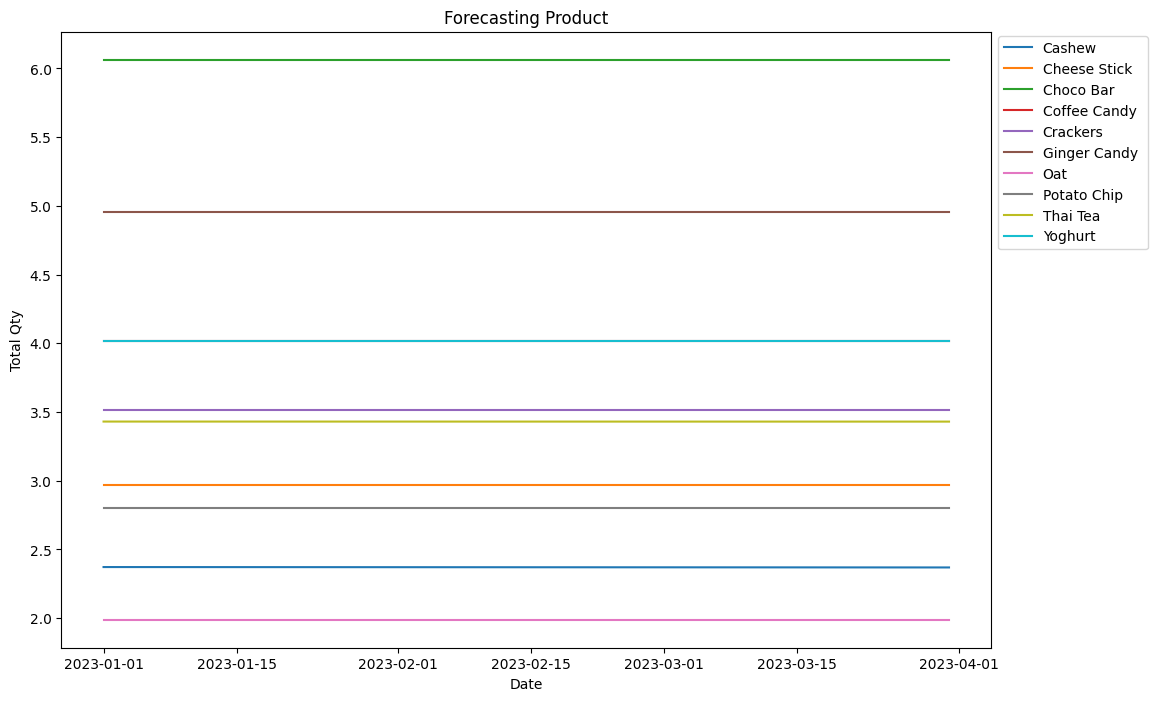

In [46]:
# PLOT FORECAST
plt.figure(figsize=(12,8))
for i in forecast_product_df.columns:
    plt.plot(forecast_product_df[i], label=i)
plt.legend(loc=6, bbox_to_anchor=(1,.82))
plt.title('Forecasting Product')
plt.xlabel('Date')
plt.ylabel('Total Qty')
plt.show()